In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import random
import seaborn as sns
import subprocess

from paretoset import paretoset
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from skopt import gp_minimize
from skopt.space import Real

### CRyPTIC Samples Ids

In [3]:
# Variations Dictionary
variation_data = open("Variations_dictionaries/CRyPTIC_dictionary.txt", "r")
contents = variation_data.read()
CRyPTIC_dictionary = ast.literal_eval(contents)
variation_data.close()

# Clinical Samples Data
initial_metadata_df = pd.read_csv("CRyPTIC_reuse_table_20231208.csv")

In [4]:
cryptic_samples = list(CRyPTIC_dictionary.keys())
cryptic_samples = [sample.split("_")[0] for sample in cryptic_samples]

In [5]:
len(cryptic_samples)

1870

In [6]:
metadata_df = initial_metadata_df[initial_metadata_df['ENA_RUN'].isin(cryptic_samples)]

In [7]:
metadata_df

,ENA_RUN,UNIQUEID,AMI_BINARY_PHENOTYPE,BDQ_BINARY_PHENOTYPE,CFZ_BINARY_PHENOTYPE,DLM_BINARY_PHENOTYPE,EMB_BINARY_PHENOTYPE,ETH_BINARY_PHENOTYPE,INH_BINARY_PHENOTYPE,KAN_BINARY_PHENOTYPE,...,INH_PHENOTYPE_QUALITY,KAN_PHENOTYPE_QUALITY,LEV_PHENOTYPE_QUALITY,LZD_PHENOTYPE_QUALITY,MXF_PHENOTYPE_QUALITY,RIF_PHENOTYPE_QUALITY,RFB_PHENOTYPE_QUALITY,ENA_SAMPLE,VCF,REGENOTYPED_VCF
5,ERR4810497,site.02.subj.0007.lab.2014222016.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298524,00/01/08/71/10871/site.02.iso.1.subject.0007.l...,00/01/08/71/10871/site.02.iso.1.subject.0007.l...
7,ERR4810507,site.02.subj.0009.lab.2014222037.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298534,00/01/08/82/10882/site.02.iso.1.subject.0009.l...,00/01/08/82/10882/site.02.iso.1.subject.0009.l...
13,ERR4810522,site.02.subj.0016.lab.2014231005.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298549,00/01/08/97/10897/site.02.iso.1.subject.0016.l...,00/01/08/97/10897/site.02.iso.1.subject.0016.l...
16,ERR4811002,site.02.subj.0019.lab.2014231015.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5300720,00/01/25/77/12577/site.02.iso.1.subject.0019.l...,00/01/25/77/12577/site.02.iso.1.subject.0019.l...
26,ERR4810553,site.02.subj.0029.lab.2014233012.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298580,00/01/09/31/10931/site.02.iso.1.subject.0029.l...,00/01/09/31/10931/site.02.iso.1.subject.0029.l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12248,ERR8699746,site.20.subj.SCH8501560.lab.YA00134942.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS6421647,00/02/84/18/28418/site.20.iso.1.subject.SCH850...,00/02/84/18/28418/site.20.iso.1.subject.SCH850...
12249,ERR8699741,site.20.subj.SCH8501564.lab.YA00134655.iso.1,S,S,S,S,S,S,S,S,...,LOW,LOW,LOW,LOW,LOW,LOW,LOW,ERS6421642,00/02/84/13/28413/site.20.iso.1.subject.SCH850...,00/02/84/13/28413/site.20.iso.1.subject.SCH850...
12255,ERR8699749,site.20.subj.SCH8508419.lab.YA00134945.iso.1,S,S,S,S,S,S,R,S,...,HIGH,HIGH,LOW,LOW,HIGH,LOW,HIGH,ERS6421649,00/02/84/20/28420/site.20.iso.1.subject.SCH850...,00/02/84/20/28420/site.20.iso.1.subject.SCH850...
12268,ERR8686598,site.20.subj.SCH8568020.lab.YA00132615.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,HIGH,ERS6422229,00/02/54/85/25485/site.20.iso.1.subject.SCH856...,00/02/54/85/25485/site.20.iso.1.subject.SCH856...


In [8]:
samples_AMI_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_BDQ_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_CFZ_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_DLM_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_EMB_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_ETH_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_INH_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_KAN_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_LEV_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_LZD_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_MXF_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

samples_RIF_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'R') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'R')]

samples_RFB_monoresistance = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'R')]

samples_MDR = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['INH_BINARY_PHENOTYPE'] == 'R') &
                          (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                          (metadata_df['RIF_BINARY_PHENOTYPE'] == 'R') &
                          (metadata_df['RFB_BINARY_PHENOTYPE'] == 'R')]

samples_SEN = metadata_df[(metadata_df['AMI_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['BDQ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['CFZ_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['DLM_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['EMB_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['ETH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['INH_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['KAN_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LEV_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['LZD_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['MXF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RIF_BINARY_PHENOTYPE'] == 'S') &
                                         (metadata_df['RFB_BINARY_PHENOTYPE'] == 'S')]

print('AMI: ', samples_AMI_monoresistance.shape[0])
print('BDQ: ', samples_BDQ_monoresistance.shape[0])
print('CFZ: ', samples_CFZ_monoresistance.shape[0])
print('DLM: ', samples_DLM_monoresistance.shape[0])
print('EMB: ', samples_EMB_monoresistance.shape[0])
print('ETH: ', samples_ETH_monoresistance.shape[0])
print('INH: ', samples_INH_monoresistance.shape[0])
print('KAN: ', samples_KAN_monoresistance.shape[0])
print('LEV: ', samples_LEV_monoresistance.shape[0])
print('LZD: ', samples_LZD_monoresistance.shape[0])
print('MXF: ', samples_MXF_monoresistance.shape[0])
print('RIF: ', samples_RIF_monoresistance.shape[0])
print('RFB: ', samples_RFB_monoresistance.shape[0])
print('MDR: ', samples_MDR.shape[0])
print('SEN: ', samples_SEN.shape[0])

AMI:  0
BDQ:  0
CFZ:  0
DLM:  0
EMB:  0
ETH:  0
INH:  645
KAN:  0
LEV:  0
LZD:  0
MXF:  0
RIF:  144
RFB:  0
MDR:  360
SEN:  647


In [9]:
# Complete samples names
def GetSamplesList(samples, all_samples):
    samples_Ids = []
    for sample in samples:
        if sample + "_lib0" in all_samples:
            samples_Ids.append(sample + "_lib0")
        elif sample + "_lib01":
            samples_Ids.append(sample + "_lib01")
        else:
            pass
    return samples_Ids

In [10]:
samples_INH_monoresistance_list = GetSamplesList(samples_INH_monoresistance['ENA_RUN'], CRyPTIC_dictionary.keys())
samples_RIF_monoresistance_list = GetSamplesList(samples_RIF_monoresistance['ENA_RUN'], CRyPTIC_dictionary.keys())
samples_MDR_list = GetSamplesList(samples_MDR['ENA_RUN'], CRyPTIC_dictionary.keys())
samples_SEN_list = GetSamplesList(samples_SEN['ENA_RUN'], CRyPTIC_dictionary.keys())

In [13]:
print("INH samples:", len(samples_INH_monoresistance_list))
print("RIF samples", len(samples_RIF_monoresistance_list))
print("MDR samples", len(samples_MDR_list))
print("SEN sample", len(samples_SEN_list))

INH samples: 645
RIF samples 144
MDR samples 360
SEN sample 647


In [35]:
samples_lists = [samples_INH_monoresistance_list, samples_RIF_monoresistance_list, samples_MDR_list, samples_SEN_list]

samples_lists_names = ["samples_INH_CRyPTIC_monoresistance_list",
                       "samples_RIF_CRyPTIC_monoresistance_list",
                       "samples_MDR_CRyPTIC_list",
                       "samples_SEN_CRyPTIC_list"]

for sample_list, list_name in zip(samples_lists, samples_lists_names):
   with open(list_name + ".txt", "w") as output:
     output.write(str(sample_list))

### Pareto Front analysis

In [2]:
# Variations Dictionary
genes_scores_data = open("gene_scores_dictionary.txt", "r")
contents = genes_scores_data.read()
genes_scores_dictionary = ast.literal_eval(contents)
genes_scores_data.close()

In [3]:
# Convert dictionary to DataFrame
genes_scores_df = pd.DataFrame.from_dict(genes_scores_dictionary, orient='index')  # 'index' to make keys rows

# Reset index to make keys the first column
genes_scores_df.reset_index(inplace=True)

# Rename columns to make it clearer
genes_scores_df.rename(columns={'index': 'Gene'}, inplace=True)

In [4]:
# Sort by the 'DAGS' column in ascending order
genes_scores_df_sorted = genes_scores_df.sort_values(by='DAGS', ascending=False)

# If you want descending order, use: df.sort_values(by='DAGS', ascending=Fals

genes_scores_df_sorted

,Gene,ADS,DAGS,CDAS,CAIS
776,rpsL,1.0000,1.0000,0.0209,0.9021
8,vapB43,0.5871,0.5553,0.0135,0.5107
1180,acpS,0.3881,0.4754,0.0000,0.4017
356,pyrR,0.4179,0.4154,0.0209,0.3767
1078,purH,0.4340,0.4016,0.0834,0.3795
...,...,...,...,...,...
1410,fas,0.0679,0.0016,0.6245,0.0838
714,eccD2,0.0382,0.0013,0.2920,0.0414
778,ctpG,0.0382,0.0013,0.2908,0.0413
978,mmpL8,0.0393,0.0010,0.3890,0.0513


#### Interactive visualization

In [5]:
# Create the 3D scatter plot
fig = px.scatter_3d(genes_scores_df_sorted, x='ADS', y='DAGS', z='CDAS', text=genes_scores_df_sorted["Gene"])

# Customize the plot appearance
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(scene=dict(xaxis_title='ADS', yaxis_title='DAGS', zaxis_title='CDAS'))
fig.update_layout(title='3D Scatter Plot of ADS, DAGS, and CDAS')
fig.update_layout(legend_title_text='Gene')
fig.update_layout(autosize=False, width=800, height=600)

# Show the interactive plot
fig.show()

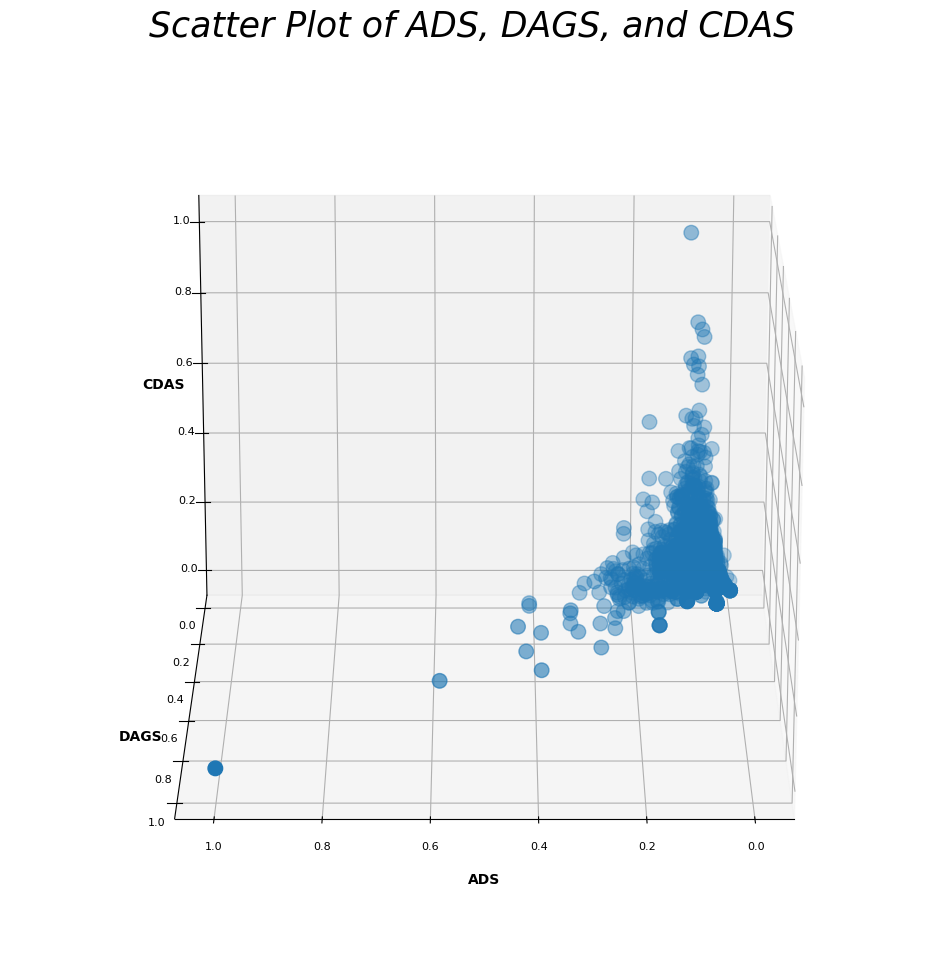

In [10]:
resolution_value = 300
# Creating dataset
x = genes_scores_df_sorted['ADS']
y = genes_scores_df_sorted['DAGS']
z = genes_scores_df_sorted['CDAS']

# Creating figure
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

plt.title("Scatter Plot of ADS, DAGS, and CDAS", style='italic', fontsize = 25)
sc = ax.scatter3D(x, y, z, s=110)

# Ticks parameters
ax.tick_params(axis='x', which='both', labelsize=8, size=3)
ax.tick_params(axis='y', which='both', labelsize=8, size=3)
ax.tick_params(axis='z', which='both', labelsize=8, size=3)

# Axes labels
ax.set_xlabel('ADS', fontsize=10, fontweight='bold', labelpad=10)
ax.set_ylabel('DAGS', fontsize=10, fontweight='bold', labelpad=10)
ax.set_zlabel('CDAS', fontsize=10, fontweight='bold', labelpad=5)

# Setting the angle of visualization
ax.view_init(elev=20, azim=90)  # Adjust elev and azim to your preference

# Show plot
fig.savefig("Scatter Plot of ADS, DAGS, and CDAS.png", format="png", dpi=resolution_value)
plt.show()


In [11]:
# Genes related to drugs suceptibillity

GoI = ["inhA", "katG", "fabG1", "rpoA", "rpoB", "rpoC",
       "rrl", "atpE", "ethA", "pncA", "fbiA", "fbiB", 
       "fgd1", "ddn", "gibB", "rsmG", "rrs", "gyrB", 
       "rpsL", "gidB", "embA", "embB", "embC"]

genes_of_interest_df = genes_scores_df_sorted[genes_scores_df_sorted["Gene"].isin(GoI)] 

In [12]:
# Create the 3D scatter plot
fig = px.scatter_3d(genes_of_interest_df, x='ADS', y='DAGS', z='CDAS', text=genes_of_interest_df["Gene"])

# Customize the plot appearance
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(scene=dict(xaxis_title='ADS', yaxis_title='DAGS', zaxis_title='CDAS'))
fig.update_layout(title='3D Scatter Plot of ADS, DAGS, and CDAS')
fig.update_layout(legend_title_text='Gene')
fig.update_layout(autosize=False, width=800, height=600)

# Show the interactive plot
fig.show()

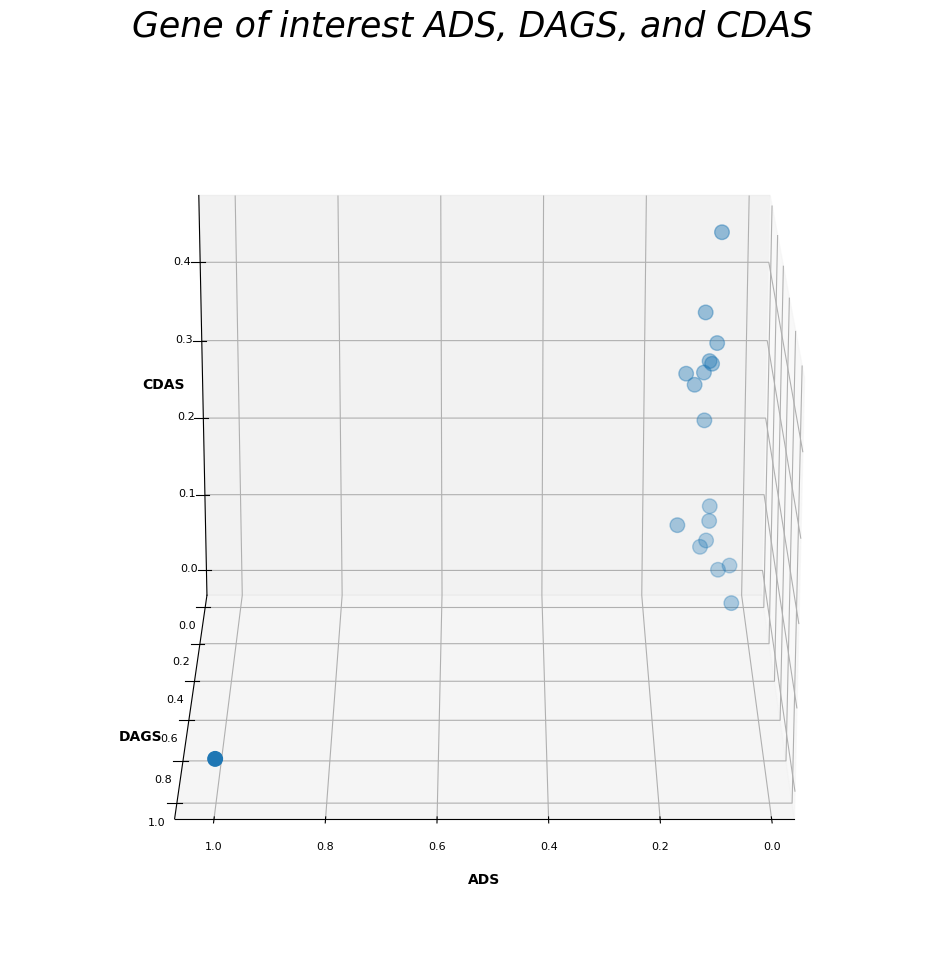

In [15]:
resolution_value = 300
# Creating dataset
x = genes_of_interest_df['ADS']
y = genes_of_interest_df['DAGS']
z = genes_of_interest_df['CDAS']

# Creating figure
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

plt.title("Gene of interest ADS, DAGS, and CDAS", style='italic', fontsize = 25)
sc = ax.scatter3D(x, y, z, s=110)

# Ticks parameters
ax.tick_params(axis='x', which='both', labelsize=8, size=3)
ax.tick_params(axis='y', which='both', labelsize=8, size=3)
ax.tick_params(axis='z', which='both', labelsize=8, size=3)

# Axes labels
ax.set_xlabel('ADS', fontsize=10, fontweight='bold', labelpad=10)
ax.set_ylabel('DAGS', fontsize=10, fontweight='bold', labelpad=10)
ax.set_zlabel('CDAS', fontsize=10, fontweight='bold', labelpad=5)

# Setting the angle of visualization
ax.view_init(elev=20, azim=90)  # Adjust elev and azim to your preference

# Show plot
fig.savefig("Gene of interest ADS, DAGS, and CDAS.png", format="png", dpi=resolution_value)
plt.show()

In [ ]:
print(min(genes_scores_df_sorted['ADS']),  genes_scores_df_sorted['ADS'].mean())
print(min(genes_scores_df_sorted['DAGS']), genes_scores_df_sorted['DAGS'].mean())
print(min(genes_scores_df_sorted['CDAS']), genes_scores_df_sorted['CDAS'].mean())
print(min(genes_scores_df_sorted['CAIS']), genes_scores_df_sorted['CAIS'].mean())

In [27]:
# Finding the Pareto set
mask = paretoset(genes_scores_df_sorted[['ADS', 'DAGS', 'CDAS']], sense=["min", "max", "max"])
paretoset_genes_scores = genes_scores_df_sorted[mask]

In [ ]:
# Initialize a list to store all Pareto fronts
pareto_fronts = []

# Keep track of the current dataset to apply Pareto set on
current_data = genes_scores_df.copy()

# Number of Pareto sets you want to retrieve
num_pareto_sets = 10

# Loop to get multiple Pareto fronts
for i in range(num_pareto_sets):
    # Get the Pareto set for the current data
    mask = paretoset(current_data[['ADS', 'DAGS', 'CDAS']], sense=["min", "max", "max"])
    
    # Add the Pareto front to the list
    pareto_front = current_data[mask]
    pareto_fronts.append(pareto_front)
    
    # Remove the current Pareto set from the data
    current_data = current_data[~mask]
    
    # Stop if there is no more data
    if current_data.empty:
        break

'''
# Display the Pareto fronts
for idx, pareto_front in enumerate(pareto_fronts, 1):
    print(f"Pareto Front {idx}:")
    print(pareto_front, "\n")
'''


### Finding Genes of Interest Depth

In [ ]:
resistance_dictionary = {"inhA": "isoniazid", "katG": "isoniazid", "fabG1": "isoniazid", "rpoA": "rifampicin", 
                         "rpoB": "rifampicin", "rpoC": "rifampicin", "gyra": "ofloxacin", "rrl": "aminoglycosides",
                         "atpE": "bedaquiline", "ethA": "ethionamide", "pncA": "pyrazinamide", "fbiA": "Delamid/Pretomanid",
                         "fbiB": "Delamid/Pretomanid", "fgd1": "Delamid/Pretomanid", "ddn": "delamid/pretomanid", 
                         "gibB": "streptomycin", "rsmG": "streptomycin", "rrs": "streptomycin", "gyrB": "ofloxacin", 
                         "rpsL": "streptomycin", "gidB": "streptomycin", "embA": "ethambutol", "embB": "ethambutol",
                         "embC": "ethambutol"}

GoI_set = set(GoI)

for pareto_front_number, pareto_front in enumerate(pareto_fronts):
    current_genes = set(pareto_front["Gene"])
    resistance_and_sensitivity = GoI_set.intersection(current_genes)
    GoI_set = GoI_set.difference(resistance_and_sensitivity)
    print("Pareto front:", pareto_front_number + 1)

    # Drug resistance association

    for gene in resistance_and_sensitivity:
        print(gene, resistance_dictionary[gene])
    print("")

### α, 𝛽, and 𝛾 Optimization process

In [3]:
def run_command_and_calculate_fitness(network_name, num_pareto_fronts, alpha, beta, gamma):
    """
    Runs the FuNTB Python script with the given alpha, beta, gamma, and returns the fitness score.

    :param network_name: Name for the network.
    :param num_pareto_fronts: Number of Pareto fronts to consider.
    :param alpha: Alpha value for CAIS calculation.
    :param beta: Beta value for CAIS calculation.
    :param gamma: Gamma value for CAIS calculation.
    :return: Fitness score, number of genes found, list of genes of interest.
    """
    # Build the command string with the given parameters
    command = f"python FuNTB.py {network_name} CRyPTIC_dictionary.txt {num_pareto_fronts} {alpha} {beta} {gamma} samples_INH_CRyPTIC_monoresistance_list.txt samples_SEN_CRyPTIC_list.txt"
    
    # Execute the command and capture the output
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    # Split the result output into lines
    output_lines = result.stdout.splitlines()
  
    # Safety check for output lines
    if len(output_lines) < 3:
        raise ValueError("Unexpected output format. Ensure the script output has at least three lines.")
    
    # Parse the fitness score and other values from the output
    fitness_score = output_lines[0]
    genes_found = eval(output_lines[1])
    genes_of_interest_list = eval(output_lines[2])

    return fitness_score, genes_found, genes_of_interest_list


#### Grid Search

In [ ]:
# Define the range of values for alpha and beta to try (gamma will be computed)
alpha_values = np.arange(0, 1.1, 0.1)  # From 0 to 1 in steps of 0.1
beta_values = np.arange(0, 1.1, 0.1)   # Same for beta
num_pareto_fronts = 5

best_fitness_score = -float('inf')  # Initialize the best fitness score
best_params = (0, 0, 0)             # Placeholder for the best alpha, beta, gamma values
iteration = 0

# Iterate over combinations of alpha and beta
for alpha in alpha_values:
    for beta in beta_values:
        gamma = 1 - (alpha + beta)  # Calculate gamma to ensure alpha + beta + gamma = 1
        
        if gamma >= 0:  # Only consider valid combinations where gamma is non-negative
            # Run your command and calculate fitness score with current alpha, beta, gamma
            fitness_score, genes_found, genes_of_interest_list = run_command_and_calculate_fitness(
                f"{alpha}{beta}{gamma}{num_pareto_fronts}", num_pareto_fronts, alpha, beta, gamma
            )
            
            iteration += 1
            print(iteration, end="\t")
            print(alpha, end="\t")
            print(beta, end="\t")
            print(gamma, end="\t")
            print(genes_found, end="\t")
            print(genes_of_interest_list, end="\t")
            print(fitness_score)

            # Update the best parameters if the current fitness score is better
            if float(fitness_score) > best_fitness_score:
                best_fitness_score = float(fitness_score)
                best_params = (alpha, beta, gamma)

# Output the best parameters and the corresponding fitness score
print(f"Best alpha, beta, gamma: {best_params}")
print(f"Best fitness score: {best_fitness_score}")


#### Random search

In [ ]:
def random_search(network_name, num_pareto_fronts, n_iter=100):
    """
    Perform random search to optimize alpha, beta, gamma parameters.
    
    :param network_name: Name for the network.
    :param num_pareto_fronts: Number of Pareto fronts to consider.
    :param n_iter: Number of iterations to sample random combinations of alpha, beta, gamma.
    :return: Best parameters and corresponding fitness score.
    """
    best_fitness_score = -float('inf')  # Initialize best fitness score
    best_params = (0, 0, 0)             # Placeholder for best parameters

    for iteration in range(n_iter):
        # Randomly sample alpha, beta, and gamma from [0, 1]
        alpha = random.uniform(0, 1)
        beta = random.uniform(0, 1)
        gamma = 1 - (alpha + beta)  # Ensure that alpha + beta + gamma = 1
        
        if gamma >= 0:  # Valid combination since gamma must be positive
            # Calculate the fitness score for the current random values
            fitness_score, genes_found, genes_of_interest_list  = run_command_and_calculate_fitness(network_name, num_pareto_fronts, alpha, beta, gamma)
            print("Iteration:", iteration, end="\t")
            print("alpha:", alpha, end="\t")
            print("beta:", beta, end="\t")
            print("gamma:", gamma, end="\t")
            print("Number of found genes:", genes_found, end="\t")
            print("Found genes:", genes_of_interest_list, end="\t")
            print("fitness score", fitness_score)

            # If this score is better than the previous best, update the best score and parameters
            if float(fitness_score) > best_fitness_score:
                best_fitness_score = float(fitness_score)
                best_params = (alpha, beta, gamma)

            

    return best_params, best_fitness_score

# Example usage
network_name = "MyNetwork"
num_pareto_fronts = 5
best_params, best_fitness_score = random_search(network_name, num_pareto_fronts, n_iter=100)

print(f"Best alpha, beta, gamma from random search: {best_params}")
print(f"Best fitness score from random search: {best_fitness_score}")


#### Bayesian

In [ ]:
from skopt import gp_minimize
from skopt.space import Real
import numpy as np

def bayesian_optimization(network_name, num_pareto_fronts):
    """
    Perform Bayesian Optimization to optimize alpha, beta, gamma parameters.
    
    :param network_name: Name for the network.
    :param num_pareto_fronts: Number of Pareto fronts to consider.
    :return: Best parameters and corresponding fitness score.
    """
    
    # Define the search space for alpha, beta between 0 and 1
    space = [
        Real(0.0, 1.0, name='alpha'),
        Real(0.0, 1.0, name='beta')
    ]

    iteration = 0  # Initialize iteration counter

    def objective(params):
        nonlocal iteration  # Allow the inner function to modify the outer iteration variable
        alpha, beta = params
        gamma = 1 - (alpha + beta)  # Ensure alpha + beta + gamma = 1

        if gamma < 0:
            return 1e10  # Penalize invalid combinations

        # Calculate the fitness score
        fitness_score, genes_found, genes_of_interest_list = run_command_and_calculate_fitness(
            network_name, num_pareto_fronts, alpha, beta, gamma
        )

        # Check for validity of fitness_score
        try:
            fitness_score = float(fitness_score)  # Attempt to convert to float
        except (ValueError, TypeError):
            return 1e10  # Penalize non-numeric or invalid fitness scores

        if not np.isfinite(fitness_score):
            return 1e10  # Penalize invalid fitness scores

        # Increment iteration counter
        iteration += 1

        # Print iteration details
        print(f"Iteration: {iteration}\talpha: {alpha}\tbeta: {beta}\tgamma: {gamma}\t"
            f"Number of found genes: {genes_found}\tFitness score: {fitness_score}")

        return -fitness_score  # Minimize the negative fitness score

    # Run Bayesian optimization to minimize the objective function
    res = gp_minimize(objective, space, n_calls=50, random_state=42)

    # Get the best alpha, beta, and gamma values
    best_alpha = res.x[0]
    best_beta = res.x[1]
    best_gamma = 1 - (best_alpha + best_beta)

    # Return the best parameters and the corresponding fitness score
    best_params = (best_alpha, best_beta, best_gamma)
    best_fitness_score = -res.fun  # Convert back since we minimized the negative

    return best_params, best_fitness_score

# Example usage
network_name = "MyNetwork"
num_pareto_fronts = 5
best_params, best_fitness_score = bayesian_optimization(network_name, num_pareto_fronts)

print(f"Best alpha, beta, gamma from Bayesian Optimization: {best_params}")
print(f"Best fitness score from Bayesian Optimization: {best_fitness_score}")


### Optimization visualization

#### Grid search

In [2]:
# Loading data
grid_search_optimization = pd.read_csv("Grid_search_optimization.txt", sep="\t", header=None)

# Columns rename
grid_search_optimization = grid_search_optimization.rename(columns={0: "Iteration",
                                                                    1: "alpha",
                                                                    2: "beta",
                                                                    3: "gamma",
                                                                    4: "Number_of_Genes_found",
                                                                    5: "Genes_found",
                                                                    6: "Fitness_score"})

# Figure plot

# Sample data
x = grid_search_optimization['alpha']
y = grid_search_optimization['beta']
z = grid_search_optimization['gamma']

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=grid_search_optimization['Fitness_score'],  # Use the 'Material_Discount' column for coloring
        colorscale='icefire_r',  # Optional: choose a colorscale
        colorbar=dict(title='Fitness score'),  # Optional: add a colorbar
        symbol='circle',
        size=4
    )
)])

# Set labels for each axis
fig.update_layout(scene=dict(
    xaxis_title='α',
    yaxis_title='𝛽',
    zaxis_title='𝛾'
))

# Set the title for the specific microorganism
fig.update_layout(title="Grid Search Optimization")

# Show the plot
fig.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Grid_search_optimization.txt'

#### Static Grid search plot

In [ ]:
resolution_value = 300
# Creating dataset
x = grid_search_optimization['alpha']
y = grid_search_optimization['beta']
z = grid_search_optimization['gamma']

# Creating figure
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

# Creating plot with a different colormap, such as 'viridis'
sc = ax.scatter3D(x, y, z, c=grid_search_optimization['Fitness_score'], cmap='inferno_r', s=110)

# Adding a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('fitness score', rotation=270, labelpad=10)

plt.title("Grid Search Optimization", style='italic', fontsize = 35)

# Ticks parameters
ax.tick_params(axis='x', which='both', labelsize=8, size=3)
ax.tick_params(axis='y', which='both', labelsize=8, size=3)
ax.tick_params(axis='z', which='both', labelsize=8, size=3)

# Axes labels
ax.set_xlabel('αlpha', fontsize=10, fontweight='bold', labelpad=10)
ax.set_ylabel('beta', fontsize=10, fontweight='bold', labelpad=10)
ax.set_zlabel('gamma', fontsize=10, fontweight='bold', labelpad=5)

# Setting the angle of visualization
ax.view_init(elev=20, azim=90)  # Adjust elev and azim to your preference

# Show plot
fig.savefig("Grid Search Optimization.png", format="png", dpi=resolution_value)
plt.show()


#### Random search

In [ ]:
# Loading data
random_search_optimization = pd.read_csv("Random_search_optimization.txt", sep="\t", header=None)

# Columns rename
random_search_optimization = random_search_optimization.rename(columns={0: "Iteration",
                                                                    1: "alpha",
                                                                    2: "beta",
                                                                    3: "gamma",
                                                                    4: "Number_of_Genes_found",
                                                                    5: "Genes_found",
                                                                    6: "Fitness_score"})

# Figure plot

# Sample data
x = random_search_optimization['alpha']
y = random_search_optimization['beta']
z = random_search_optimization['gamma']

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=random_search_optimization['Fitness_score'],
        colorscale='icefire_r',  # Optional: choose a colorscale
        colorbar=dict(title='Fitness score'),  # Optional: add a colorbar
        symbol='circle',
        size=4
    )
)])

# Set labels for each axis
fig.update_layout(scene=dict(
    xaxis_title='α',
    yaxis_title='𝛽',
    zaxis_title='𝛾'
))

# Set the title for the specific microorganism
fig.update_layout(title="Random Search Optimization")

# Show the plot
fig.show()

#### Static Random Search

In [ ]:
resolution_value = 300
# Creating dataset
x = random_search_optimization['alpha']
y = random_search_optimization['beta']
z = random_search_optimization['gamma']

# Creating figure
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

# Creating plot with a different colormap, such as 'viridis'
sc = ax.scatter3D(x, y, z, c=random_search_optimization['Fitness_score'], cmap='inferno_r', s=110)

# Adding a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('fitness score', rotation=270, labelpad=10)

plt.title("Random Search Optimization", style='italic', fontsize = 35)

# Ticks parameters
ax.tick_params(axis='x', which='both', labelsize=8, size=3)
ax.tick_params(axis='y', which='both', labelsize=8, size=3)
ax.tick_params(axis='z', which='both', labelsize=8, size=3)

# Axes labels
ax.set_xlabel('αlpha', fontsize=10, fontweight='bold', labelpad=10)
ax.set_ylabel('beta', fontsize=10, fontweight='bold', labelpad=10)
ax.set_zlabel('gamma', fontsize=10, fontweight='bold', labelpad=5)

# Setting the angle of visualization
ax.view_init(elev=20, azim=90)  # Adjust elev and azim to your preference

# Show plot
fig.savefig("Random Search Optimization.png", format="png", dpi=resolution_value)
plt.show()


#### Bayesian search

In [ ]:
# @Bayesian Search Optimization Process Graph
# Loading data
bayesian_search_optimization = pd.read_csv("Bayesian_optimization.txt", sep="\t", header=None)

# Columns rename
bayesian_search_optimization = bayesian_search_optimization.rename(columns={0: "Iteration",
                                                                    1: "alpha",
                                                                    2: "beta",
                                                                    3: "gamma",
                                                                    4: "Number_of_Genes_found",
                                                                    5: "Fitness_score"})
# Figure plot

# Sample data
x = bayesian_search_optimization['alpha']
y = bayesian_search_optimization['beta']
z = bayesian_search_optimization['gamma']

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=bayesian_search_optimization['Fitness_score'],
        colorscale='icefire_r',  # Optional: choose a colorscale
        colorbar=dict(title='Fitness score'),  # Optional: add a colorbar
        symbol='circle',
        size=4
    )
)])

# Set labels for each axis
fig.update_layout(scene=dict(
    xaxis_title='α',
    yaxis_title='𝛽',
    zaxis_title='𝛾'
))

# Set the title for the specific microorganism
fig.update_layout(title="Bayesian Search Optimization")

# Show the plot
fig.show()

#### Static Bayesian Optimization

In [ ]:
resolution_value = 300
# Creating dataset
x = bayesian_search_optimization['alpha']
y = bayesian_search_optimization['beta']
z = bayesian_search_optimization['gamma']

# Creating figure
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection="3d")

# Creating plot with a different colormap, such as 'viridis'
sc = ax.scatter3D(x, y, z, c=bayesian_search_optimization['Fitness_score'], cmap='inferno_r', s=110)

# Adding a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('fitness score', rotation=270, labelpad=10)

plt.title("Bayesian Search Optimization", style='italic', fontsize = 35)

# Ticks parameters
ax.tick_params(axis='x', which='both', labelsize=8, size=3)
ax.tick_params(axis='y', which='both', labelsize=8, size=3)
ax.tick_params(axis='z', which='both', labelsize=8, size=3)

# Axes labels
ax.set_xlabel('αlpha', fontsize=10, fontweight='bold', labelpad=10)
ax.set_ylabel('beta', fontsize=10, fontweight='bold', labelpad=10)
ax.set_zlabel('gamma', fontsize=10, fontweight='bold', labelpad=5)

# Setting the angle of visualization
ax.view_init(elev=20, azim=90)  # Adjust elev and azim to your preference

# Show plot
fig.savefig("Bayesian Search Optimization.png", format="png", dpi=resolution_value)
plt.show()


### Coefficients statistical significance 

#### Buffer zone

Define a "buffer zone" around optimal parameters and exclude random values that fall within this zone. For example, to ensure the random samples are not too close to the optimal.

In [ ]:
# Optimal alpha, beta, gamma from your optimization
optimal_alpha = 0.9385527090157504
optimal_beta = 0.0007787658410143285
optimal_gamma = 0.060668525143235286

# Define a buffer zone, say 5% around the optimal values
alpha_buffer = 0.05
beta_buffer = 0.05

# Number of random samples to generate
n_random_samples = 1000

random_scores = []
network_name = "Statistical_analysis_network"
num_pareto_fronts = 5

def is_in_buffer(value, optimal_value, buffer):
    return optimal_value - buffer <= value <= optimal_value + buffer

for _ in range(n_random_samples):
    while True:
        alpha = np.random.uniform(0, 1)
        beta = np.random.uniform(0, 1 - alpha)
        gamma = 1 - (alpha + beta)

        # Ensure that alpha, beta, gamma are not in the buffer zone
        if (not is_in_buffer(alpha, optimal_alpha, alpha_buffer) and
            not is_in_buffer(beta, optimal_beta, beta_buffer) and
            gamma >= 0):
            break  # Found valid alpha, beta, gamma outside the buffer zone

    # Calculate fitness score
    fitness_score, _, _ = run_command_and_calculate_fitness(network_name, num_pareto_fronts, alpha, beta, gamma)
    random_scores.append(fitness_score)

# Convert to a NumPy array for statistical testing
random_scores = np.array(random_scores, dtype=np.float64)

# Optimized fitness score
optimized_fitness_score = [optimal_alpha, optimal_beta,	optimal_gamma]  # From your optimization results

# Perform one-sample t-test to compare optimized fitness score with random scores
t_stat, p_value = ttest_1samp(random_scores, optimized_fitness_score)

print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The optimized fitness score is significantly different from random parameter fitness scores!")
else:
    print("No significant difference between optimized and random parameter fitness scores.")

In [ ]:
# Optimized fitness score
optimized_fitness_score = 0.45  # From your optimization results

# Perform one-sample t-test to compare optimized fitness score with random scores
t_stat, p_value = ttest_1samp(random_scores, optimized_fitness_score)

print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The optimized fitness score is significantly different from random parameter fitness scores!")
else:
    print("No significant difference between optimized and random parameter fitness scores.")

#### Perturbation for "Near-Optimal" Samples

Generate perturbed values around the optimal α, β, and γ. This can be done by adding a large enough random noise (e.g., 10-15%) to the optimal values, ensuring that the values are different but still comparable to the optimal set.

In [ ]:
perturbation_strength = 0.15  # Define a perturbation level (15% deviation)

perturbed_scores = []
for i in range(n_random_samples):
    print("Iteration:", i)
    # Perturb the optimal parameters by adding noise
    alpha = np.clip(optimal_alpha + np.random.uniform(-perturbation_strength, perturbation_strength), 0, 1)
    beta = np.clip(optimal_beta + np.random.uniform(-perturbation_strength, perturbation_strength), 0, 1 - alpha)
    gamma = 1 - (alpha + beta)
    
    # Calculate fitness score for the perturbed parameters
    fitness_score, _, _ = run_command_and_calculate_fitness(network_name, num_pareto_fronts, alpha, beta, gamma)
    perturbed_scores.append(fitness_score)

# Convert to a NumPy array for statistical testing
perturbed_scores = np.array(random_scores, dtype=np.float64)

# Optimized fitness score
optimized_fitness_score = 0.45  # From your optimization results

# Perform one-sample t-test to compare optimized fitness score with random scores
t_stat, p_value = ttest_1samp(perturbed_scores, optimized_fitness_score)

print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The optimized fitness score is significantly different from random parameter fitness scores!")
else:
    print("No significant difference between optimized and random parameter fitness scores.")

In [ ]:
# Convert to a NumPy array for statistical testing
perturbed_scores = np.array(random_scores, dtype=np.float64)

# Optimized fitness score
optimized_fitness_score = 0.45  # From your optimization results

# Perform one-sample t-test to compare optimized fitness score with random scores
t_stat, p_value = ttest_1samp(perturbed_scores, optimized_fitness_score)

print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The optimized fitness score is significantly different from random parameter fitness scores!")
else:
    print("No significant difference between optimized and random parameter fitness scores.")

In [ ]:
perturbed_scores

#### Random and Perturbated vs Optimal scores

### Scores Statistifal significance